# Exploratory Data Analysis

## Library Import

In [14]:
import re
import string
import collections

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import emoji

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (9, 5)

## Config

In [15]:
DATA_PATH = "data/email_spam_indo.csv"
TEXT_COL = "Pesan"
LABEL_COL = "Kategori"

## Load Data

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."


Shape: (2636, 2)
Columns: ['Kategori', 'Pesan']

Missing values per column:


Series([], dtype: int64)

Duplicate rows: 16


Kategori
spam    1368
ham     1268
Name: count, dtype: int64

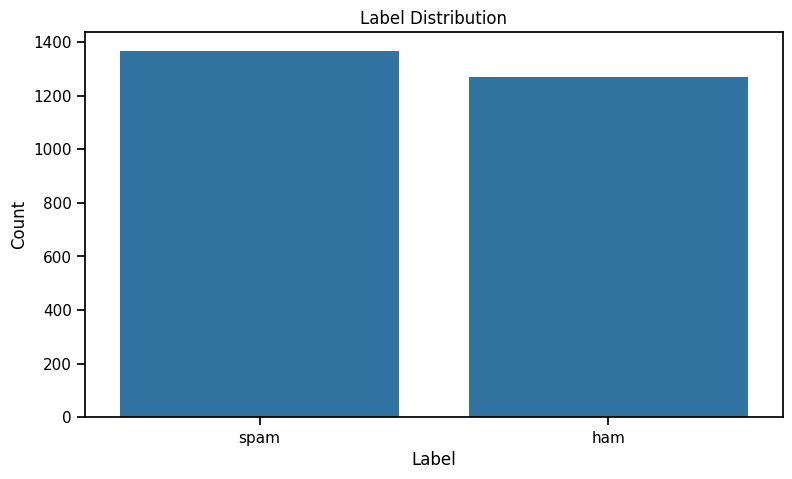

In [16]:
df = pd.read_csv(DATA_PATH)
df = df.rename(columns=str.strip)

display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Missing values & duplicates
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:")
display(missing[missing > 0])

dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Label distribution
label_counts = df[LABEL_COL].value_counts()
display(label_counts)

plt.figure()
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Text Cleaning

In [17]:
STOPWORDS = set(StopWordRemoverFactory().get_stop_words())
STOPWORDS.update({
    "hou", "kaminski", "vince", "enron", "corp", "edu", "cc", "re", "fw", "subject",
    "email", "houston", "pm", "am", "com", "net", "org", "ltd", "co", "inc", "ect"
})

URL_RE = re.compile(r"https?://\S+|www\.\S+")
EMAIL_RE = re.compile(r"\S+@\S+")
NUM_RE = re.compile(r"\d+")
MULTISPACE_RE = re.compile(r"\s+")

# Emoji remover (compat untuk versi emoji berbeda)
if hasattr(emoji, "get_emoji_regexp"):
    EMOJI_RE = emoji.get_emoji_regexp()
    def strip_emoji(txt: str) -> str:
        return EMOJI_RE.sub(" ", txt)
else:
    def strip_emoji(txt: str) -> str:
        return emoji.replace_emoji(txt, replace=" ")

PUNCT_TABLE = str.maketrans("", "", string.punctuation)

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = URL_RE.sub(" ", text)
    text = EMAIL_RE.sub(" ", text)
    text = strip_emoji(text)
    text = text.translate(PUNCT_TABLE)
    text = NUM_RE.sub(" ", text)

    tokens = text.split()
    tokens = [t for t in tokens if t.isalpha() and len(t) > 2 and t not in STOPWORDS]

    cleaned = " ".join(tokens)
    cleaned = MULTISPACE_RE.sub(" ", cleaned).strip()
    return cleaned

df["clean_text"] = df[TEXT_COL].apply(clean_text)

display(df[[TEXT_COL, "clean_text", LABEL_COL]].head(5))

,Pesan,clean_text,Kategori
0,Secara alami tak tertahankan identitas perusah...,alami tak tertahankan identitas perusahaan san...,spam
1,Fanny Gunslinger Perdagangan Saham adalah Merr...,fanny gunslinger perdagangan saham merrill muz...,spam
2,Rumah -rumah baru yang luar biasa menjadi muda...,rumah rumah baru luar biasa menjadi mudah menu...,spam
3,4 Permintaan Khusus Pencetakan Warna Informasi...,permintaan khusus pencetakan warna informasi t...,spam
4,"Jangan punya uang, dapatkan CD perangkat lunak...",jangan punya uang dapatkan perangkat lunak sin...,spam


## Text Length Analysis

,len_raw,len_clean
count,2636.000000,2636.000000
mean,1481.520106,955.869879
std,2215.573869,1506.250756
min,3.000000,3.000000
25%,446.000000,295.750000
50%,860.000000,520.500000
75%,1626.000000,1002.250000
max,33531.000000,22907.000000


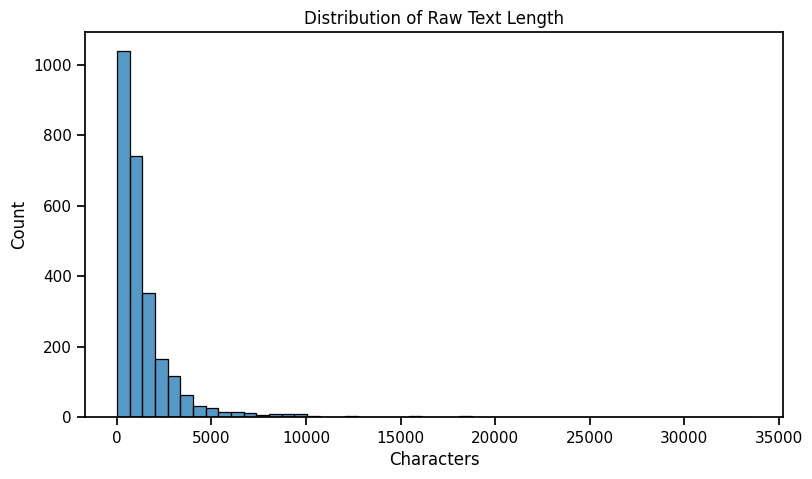

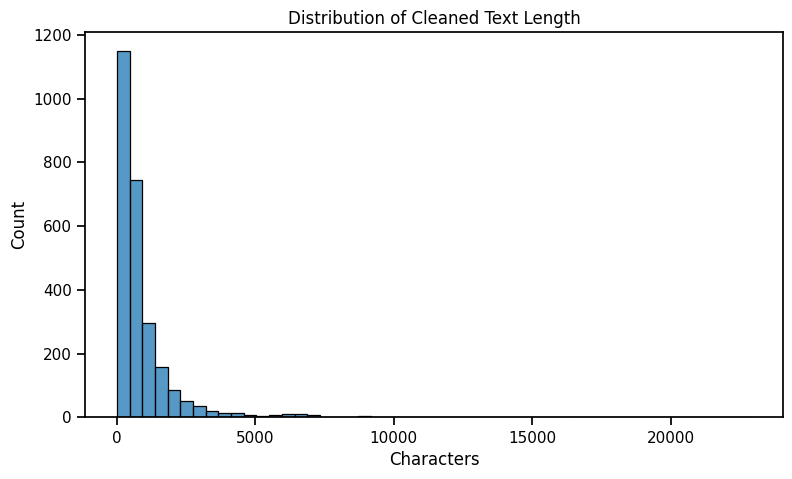

In [21]:
df["len_raw"] = df[TEXT_COL].astype(str).str.len()
df["len_clean"] = df["clean_text"].astype(str).str.len()

display(df[["len_raw", "len_clean"]].describe())

plt.figure()
sns.histplot(df["len_raw"], bins=50)
plt.title("Distribution of Raw Text Length")
plt.xlabel("Characters")
plt.show()

plt.figure()
sns.histplot(df["len_clean"], bins=50)
plt.title("Distribution of Cleaned Text Length")
plt.xlabel("Characters")
plt.show()

## Top Tokens per Label

In [22]:
def top_tokens(texts, top_k=30):
    counter = collections.Counter()
    for t in texts:
        counter.update(str(t).split())
    return counter.most_common(top_k)

labels = df[LABEL_COL].unique().tolist()
print("Labels:", labels)

for lab in labels:
    subset = df[df[LABEL_COL] == lab]
    common = top_tokens(subset["clean_text"], top_k=5)
    print(f"\nTop tokens for label = {lab}")
    display(pd.DataFrame(common, columns=["token", "count"]))

Labels: ['spam', 'ham']

Top tokens for label = spam


,token,count
0,lebih,1414
1,perusahaan,1198
2,situs,937
3,semua,848
4,bisnis,790



Top tokens for label = ham


,token,count
0,subjek,1103
1,terima,1055
2,kasih,1043
3,hari,982
4,memiliki,843


## WordCloud

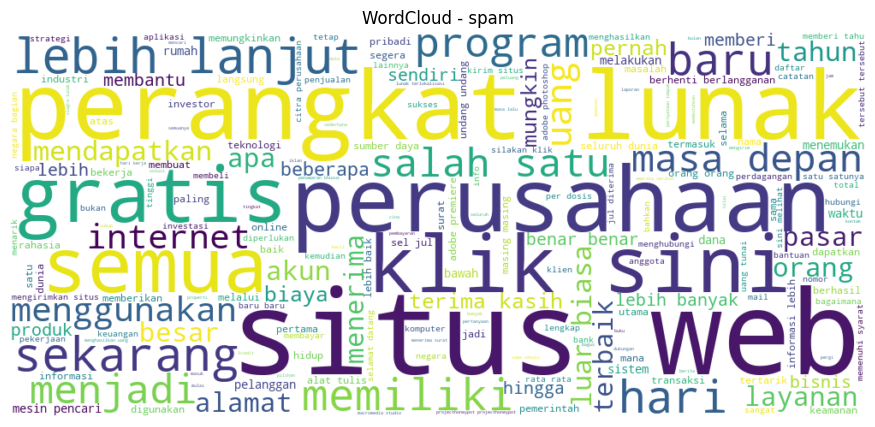

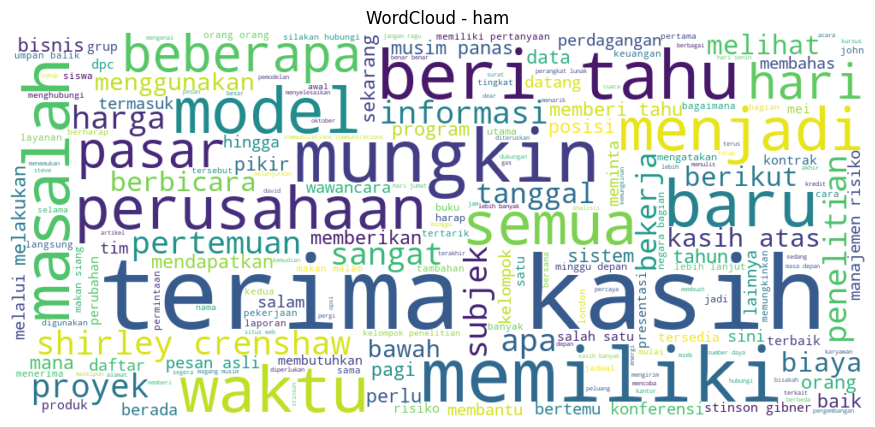

In [23]:
def show_wordcloud(texts, title):
    text_blob = " ".join(texts.astype(str).tolist())
    wc = WordCloud(width=1000, height=450, background_color="white").generate(text_blob)

    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for lab in labels:
    subset = df[df[LABEL_COL] == lab]
    show_wordcloud(subset["clean_text"], f"WordCloud - {lab}")


## Bigram

In [24]:
def top_bigrams(texts, top_k=10):
    counter = collections.Counter()
    for t in texts.astype(str):
        tokens = t.split()
        bigrams = zip(tokens, tokens[1:])
        counter.update([" ".join(bg) for bg in bigrams])
    return counter.most_common(top_k)

for lab in labels:
    subset = df[df[LABEL_COL] == lab]
    common_bg = top_bigrams(subset["clean_text"], top_k=25)
    print(f"\nTop bigrams for label = {lab}")
    display(pd.DataFrame(common_bg, columns=["bigram", "count"]))


Top bigrams for label = spam


,bigram,count
0,situs web,615
1,perangkat lunak,421
2,klik sini,340
3,http www,311
4,lebih lanjut,299
5,salah satu,207
6,masa depan,207
7,luar biasa,174
8,terima kasih,153
9,lebih banyak,145



Top bigrams for label = ham


,bigram,count
0,terima kasih,1027
1,beri tahu,405
2,shirley crenshaw,280
3,kasih atas,212
4,musim panas,203
5,memberi tahu,189
6,manajemen risiko,160
7,http www,156
8,pesan asli,153
9,stinson gibner,143


## Text Samples

In [25]:
for lab in labels:
    print(f"\nSamples for label = {lab}")
    display(df[df[LABEL_COL] == lab][[TEXT_COL, "clean_text"]].sample(5, random_state=42))


Samples for label = spam


,Pesan,clean_text
427,Re: Kesempatan Pendidikan Kami berbicara tenta...,kesempatan pendidikan berbicara universitas me...
1087,Logo dan identitas khusus dari kami berpikir u...,logo identitas khusus berpikir menghirup kehid...
668,Penghematan tepercaya pada obat resep. Sekaran...,penghematan tepercaya obat resep sekarang mend...
572,"OUUR MEDZ Halo, Selamat datang di Farmonli Mai...",ouur medz halo selamat datang farmonli mailbox...
115,FW: Saya tidak sehat. Pada tahun 1839 tidak sa...,sehat tahun sama sekali soccerwe sini coca cola



Samples for label = ham


,Pesan,clean_text
2580,Permohonan Eksekutif United Way Seperti yang A...,permohonan eksekutif united way ketahui ajakan...
2170,ISO New England dan PJM mengusulkan pesan desa...,iso new england pjm mengusulkan pesan desain p...
1790,"Re: Hubungi Info Glenn, silakan, hubungi Rudi ...",hubungi info glenn silakan hubungi rudi zipter...
2342,"Lanjutkan, cv. , dll . MR. Kaminski: Seperti y...",lanjutkan dijelaskan melalui telepon melakukan...
2176,FWD: Daftar Terbaru - Rice Mari kita coba ini ...,fwd daftar terbaru rice coba pam tanggal rabu ...
